## Imports

In [ ]:
from scipy.io import loadmat
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sbn
import mne
import matplotlib.pyplot as plt

## Constants

In [82]:
COMPLEX_MEASURES = ['Entropy_Shannon', 'Entropy_Sample', 'Entropy_Multiscale', 'Entropy_Spectral', 'Entropy_SVD', 
                    'Fractal_Dimension_Correlation', 'Fractal_Higuchi', 'Fractal_Petrosian', 'Fisher_Information',
                    'Hurst', 'DFA']
COMPLEX = ['Spectral Entropy', 'Entropy SVD', 'Higushi','Petrosian Fractality', 'Fisher', 'Hurst']
COMPLEX2 = ['Spectral Entropy', 'Petrosian Fractality']

PARTICIPANTS = ['01', '04', '05', '06', '07', '09', '11', '12', '13', '14']

event_id_cond_names = ['Percept', 'Imagine_cued']

FREQ_BANDS = [[1, 3], [4, 7], [8, 12], [13, 29], [30, 45]]
FREQ_NAMES = ['delta', 'theta', 'alpha', 'beta', 'gamma']
EEG = [i for i in range(64)]

## Load and arrange data

In [5]:
## Load one .fif to get the electrodes positions. This will be used subsequently in mne.viz.plot_topomap
#Load Epoched data
data_path = r'C:\Users\Dell\Jupyter\MNE_python'    
fnames = (data_path + '\\' + 'epoched_data_cond' + '07' +'.fif.gz') #epoched_data_cond for simple percept/imagine contrast                                                                     #epoched_data for havinf song contrast as well
epoched_data = mne.read_epochs(fnames, preload=True)
#Get EEG 64 electrodes layout positions    
layout = mne.channels.find_layout(epoched_data.info, ch_type='eeg')
ch_xy = layout.pos[:,0:2]

Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond07.fif.gz ...


<ipython-input-5-816548a1d9da>:5: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond07.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated


In [117]:
# Load matrix of complexity
#participant*condition*trial*electrode*complexity_measure
#SVD, Higushi, Fisher, Hurst
x = loadmat('spectral_theta')
comp_mat_init = np.array(x['complexity'])

complex_tot = []
for p in range(10):
    complex_p4 = []
    for c in range(2):
        complex_p3 = []
        for t in range(60):
            complex_p2 = []
            for e in range(64):
                complex_p = []
                for comp in range(2):
                    complex_p.append(comp_mat_init[p][c][t][e][0][0][comp][0][0])
                complex_p2.append(complex_p)
            complex_p3.append(complex_p2)
        complex_p4.append(complex_p3)
    complex_tot.append(complex_p4)

complex_tot = np.array(complex_tot)           #participant*condition*trial*electrode*complexity_measure
                                              #complex_tot.shape = 10*2*60*64*4
complex_avg_c = np.mean(complex_tot, axis=0)  #average across participants
complex_avg_p = np.mean(complex_tot, axis=2)  #average across trials

## Functions

In [96]:
def p_values_boolean_comp(p_values, thresh):
    p_values_boolean = p_values.copy()
    for e in range(p_values.shape[1]):
        for c in range(p_values.shape[0]):
            if p_values[c, e] < thresh:
                p_values_boolean[c, e] = True
            else:
                p_values_boolean[c, e] = False
    p_values_boolean = np.array(p_values_boolean, dtype='bool')                
    return(p_values_boolean)


def array_topoplot(toplot, ch_xy, showtitle=False, titles=None, savefig=True, figpath=r'C:\Users\Dell\Jupyter\BrainHackSchool2019_AB\complex', vmin=-1, vmax=1, mask=None):
    #create fig
    fig, ax = plt.subplots(1,len(toplot), figsize=(20,10))
    #create a topomap for each data array
    for i, data in enumerate(toplot):
        image,_ = mne.viz.plot_topomap(data=data, pos=ch_xy, cmap='magma', vmin=vmin, vmax=vmax, axes=ax[i], show=False, mask = mask[i, :])
        #option for title
        if showtitle == True:
            ax[i].set_title(titles[i], fontdict={'fontsize': 15, 'fontweight': 'heavy'})
    #add a colorbar at the end of the line (weird trick from https://www.martinos.org/mne/stable/auto_tutorials/stats-sensor-space/plot_stats_spatio_temporal_cluster_sensors.html#sphx-glr-auto-tutorials-stats-sensor-space-plot-stats-spatio-temporal-cluster-sensors-py)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[-1])
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_colorbar.tick_params(labelsize=8)
    #save plot if specified
    if savefig == True:
        plt.savefig(figpath, dpi=300)
    plt.show()
    return fig, ax


## T-test

In [118]:
#Compute t-test for each electrode on complexity measures on 10 participants averaged by trials

results = []
for complex in range(complex_avg_c.shape[3]):
    results_temp = []
    for elec in range(complex_avg_c.shape[2]):
        percept_complex = complex_avg_c[0, :, elec, complex]
        imagine_complex = complex_avg_c[1, :, elec, complex]

        results_temp.append(stats.ttest_rel(percept_complex, imagine_complex))
    results.append(results_temp)
    complex_t_test_trials = np.array(results)
    t_values_trials = complex_t_test_trials[:,:,0]
    p_values_trials = complex_t_test_trials[:,:,1]
#Creates an array of booleans to use as a mask in the topomap plotting
p_values_trials_boolean = p_values_boolean_comp(p_values_trials, 0.05)

#Compute t-test for each electrode on complexity measures on 60 trials averaged by participants
results2 = []
for complex in range(complex_avg_p.shape[3]):
    results_temp = []
    for elec in range(complex_avg_p.shape[2]):
        percept_complex = complex_avg_p[:, 0, elec, complex]
        imagine_complex = complex_avg_p[:, 1, elec, complex]

        results_temp.append(stats.ttest_rel(percept_complex, imagine_complex))
    results2.append(results_temp)
    complex_t_test_participants = np.array(results2)
    t_values_participants = complex_t_test_participants[:,:,0]
    p_values_participants = complex_t_test_participants[:,:,1]
#Creates an array of booleans to use as a mask in the topomap plotting
p_values_participants_boolean = p_values_boolean_comp(p_values_participants, 0.05)

## Plot topomaps of t-values with mask of p values

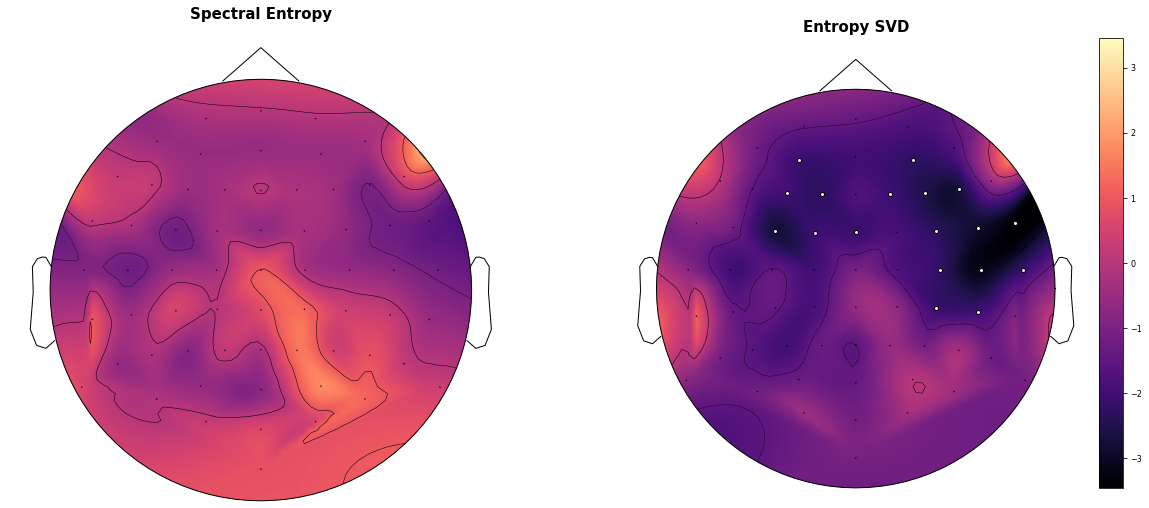

In [119]:
value_to_plot = t_values_trials
extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot))))))
vmax = extreme
vmin = -extreme
#value_to_plot2 = psds_percept_avg
array_topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=COMPLEX, mask=p_values_trials_boolean);
#array_topoplot(value_to_plot2, ch_xy, vmin=np.min(np.min(np.array(value_to_plot2))), vmax=np.max(np.max(np.array(value_to_plot2))), showtitle=True, titles=FREQ_NAMES);

## Hilbert Transform

## Violin plots

In [ ]:
complex_test = complex_avg_p.copy()
complex_test = complex_test[:, :, :, 1] # takes only first complexity measure
complex_test = np.average(complex_test, axis=0)
#complex_test=complex_test.squeeze()
complex_test.shape

In [ ]:
complex_df = pd.DataFrame()
complex_df['Percept'] = complex_test[0, :]
complex_df['Imagine'] = complex_test[1, :]

In [ ]:
plot_A_vs_B(complex_test[0, :], complex_test[1, :], event_id_cond_names, pval=None, met='Spectral')

In [ ]:
def plot_A_vs_B(comp_cond1, comp_cond2, cond_names, pval, met, ax=None):
    ######### Create a boxplot
    
    #### Create dataframe for Seaborn
    values = np.hstack((comp_cond1, comp_cond2))
    condition = np.hstack(([cond_names[0]]*len(comp_cond1), [cond_names[1]]*len(comp_cond2)))
    d = {'Values': values, 'Condition': condition}
    df = pd.DataFrame(data=d)
    
    if ax == None:
        f, ax = plt.subplots(figsize=(7, 6))
    
    # Create boxes
    sbn.boxplot(x="Condition", y="Values", data=df,
                whis="range", ax=ax)
    
    if len(comp_cond1) >= 50: # If n_epochs > 50 we use a violinplot  
        sbn.violinplot(x="Condition", y="Values", data=df,
                      size=2, linewidth=0.5, ax=ax, palette='vlag')
    else: # Add in points to show each observation
        sbn.swarmplot(x="Condition", y="Values", data=df,
              size=10, linewidth=0.5, ax=ax, palette='vlag')
    
    # Tweak the visual presentation
    ax.xaxis.grid(True);
    sbn.despine(trim=True, left=True, ax=ax)
    
    # Add pvals in title
    if pval <= 0.05 and pval >= 0.001:
        ax.set_title(met + ' *')
    elif pval <= 0.001 and pval >= 0.0001:
        ax.set_title(met + ' **')
    elif pval <= 0.0001:
        ax.set_title(met + ' ***')
    else:
        ax.set_title(met)
        
    return ax

In [ ]:
test_hilbert= epoched_data['07'][119].get_data()

In [ ]:
test_hilbert = test_hilbert[:, 0, :].squeeze()
test_hilbert.shape

In [ ]:
!pip install brainpipe
#import brainpipe
from brainpipe.feature import power